In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import TensorBoard
from callback_for_tb import write_log, write_img
from visualize_layer import visualize_layer

In [2]:
import sys
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 # Noiseの次元を決めている。
        optimizer = Adam(0.0002, 0.5)
        
        # KTF.set_learning_phase(1) # Tensorboard用。learning_phaseはTrainingとTestで動作が異なる場合に使用。

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = True       
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)
        
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
              
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
             
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    def build_generator(self):
        model = Sequential()  
        model.add(Dense(100, input_dim=self.latent_dim))
        model.add(Reshape((10, 10, -1)))
        model.add(Conv2DTranspose(128, (5, 5), strides=1, padding='valid'))
        model.add(Conv2DTranspose(128, (2, 2), strides=1, padding='same'))
        model.add(Conv2DTranspose(128, (2, 2), strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(AveragePooling2D((2, 2), strides=1, padding='same'))
        model.add(Conv2DTranspose(64, (2, 2), strides=2, padding='valid'))
        model.add(Conv2DTranspose(64, (2, 2), strides=1, padding='same'))
        model.add(Conv2DTranspose(64, (2, 2), strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(AveragePooling2D((2, 2), strides=1, padding='same'))
        model.add(Dense(1, activation='tanh')) # activation='tanh'なので-1,1の範囲の値を持つ。
        # model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        log_path = './my_log_dir'
        callback = TensorBoard(log_dir='./my_log_dir')
        callback.set_model(self.combined)
        train_names = ['d_loss', 'd_acc']
        val_names = ['g_loss', 'g_acc']
        
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3) # Insert a new axis.

        # Adversarial ground truths
        valid_1 = np.ones((batch_size, 1))
        fake_0 = np.zeros((batch_size, 1))
        valid = (1.2 - 0.7) * np.random.rand(batch_size, 1) + 0.7
        fake = (0.3 - 0.0) * np.random.rand(batch_size, 1) + 0.0
        
        for epoch in range(epochs+1):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid) # 単一バッチデータにつき一度の勾配更新を行う。
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            # train_on_batchは学習の損失を表すスカラ値（モデルが単一の出力を持ち，かつ評価関数がない場合），
            # モデルが複数の出力や評価関数metrics=['accuracy']を持つ場合はスカラ値のリストを戻り値として返す。
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # The arrays to be added. If x1.shape != x2.shape,>-broadcast
            
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid_1)        
            
            # Plot the progress            
            # print ("%d [D loss: %f] [G loss: %f, G acc.: %.2f%%]" % (epoch, d_loss[0], g_loss[0], 100*g_loss[1]))
            # print ("%d [R_acc: %.2f%%, F_acc.: %.2f%%] [G_acc.: %.2f%%]" % (epoch, 100*d_loss_real[1], 100*d_loss_fake[1], 100*g_loss[1]))
            write_log(callback, train_names, d_loss, epoch)
            write_log(callback, val_names, g_loss, epoch)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                fig, name = self.sample_images(epoch)
                write_img(callback, name, fig, epoch)
                print ("%d [D loss: %f] [G loss: %f, G acc.: %.2f%%]" % (epoch, d_loss[0], g_loss[0], 100*g_loss[1]))

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        name = str(epoch) + '.png'
        return fig, name
        # fig.savefig("images/%d.png" % epoch)
        # plt.close()

In [4]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

0 [D loss: 0.505813] [G loss: 1.216040, G acc.: 12.50%]
5000 [D loss: 0.540392] [G loss: 1.336161, G acc.: 12.50%]
10000 [D loss: 0.613419] [G loss: 1.342902, G acc.: 6.25%]
15000 [D loss: 0.504664] [G loss: 1.105584, G acc.: 25.00%]
20000 [D loss: 0.479334] [G loss: 1.299575, G acc.: 9.38%]
25000 [D loss: 0.551183] [G loss: 1.234151, G acc.: 18.75%]


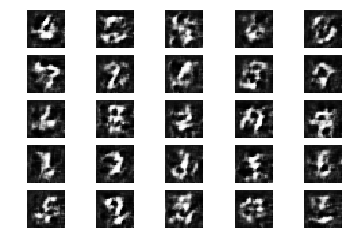

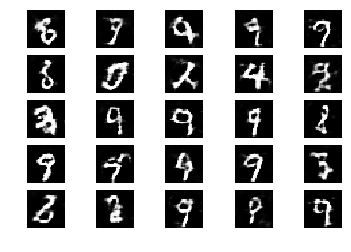

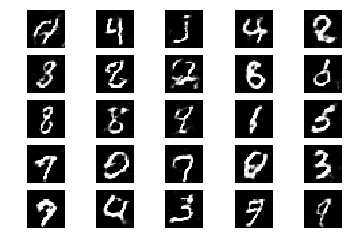

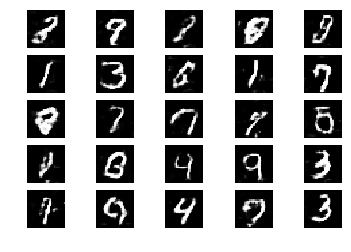

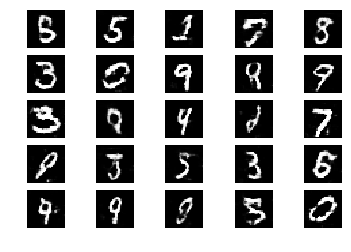

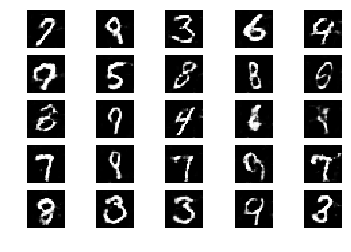

In [39]:
gan.train(epochs=30000, batch_size=32, sample_interval=5000)

In [40]:
gan.generator.save('./saved_model/gan_by_cnnT_generator.h5')
gan.discriminator.save('./saved_model/gan_by_cnnT_discriminator.h5')
gan.combined.save('./saved_model/gan_by_cnnT_combined.h5')
# LeakyReLUを別のLayerにしないとsaveできないよう。

In [5]:
from keras.models import load_model
from keras.models import load_model
generator = load_model('./saved_model/gan_by_cnnT_generator.h5')
model = generator.layers[1]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
reshape_11 (Reshape)         (None, 10, 10, 1)         0         
_________________________________________________________________
conv2d_transpose_77 (Conv2DT (None, 14, 14, 128)       3328      
_________________________________________________________________
conv2d_transpose_78 (Conv2DT (None, 14, 14, 128)       65664     
_________________________________________________________________
conv2d_transpose_79 (Conv2DT (None, 14, 14, 128)       65664     
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 14, 14, 128)       512       
__________

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


conv2d_transpose_77


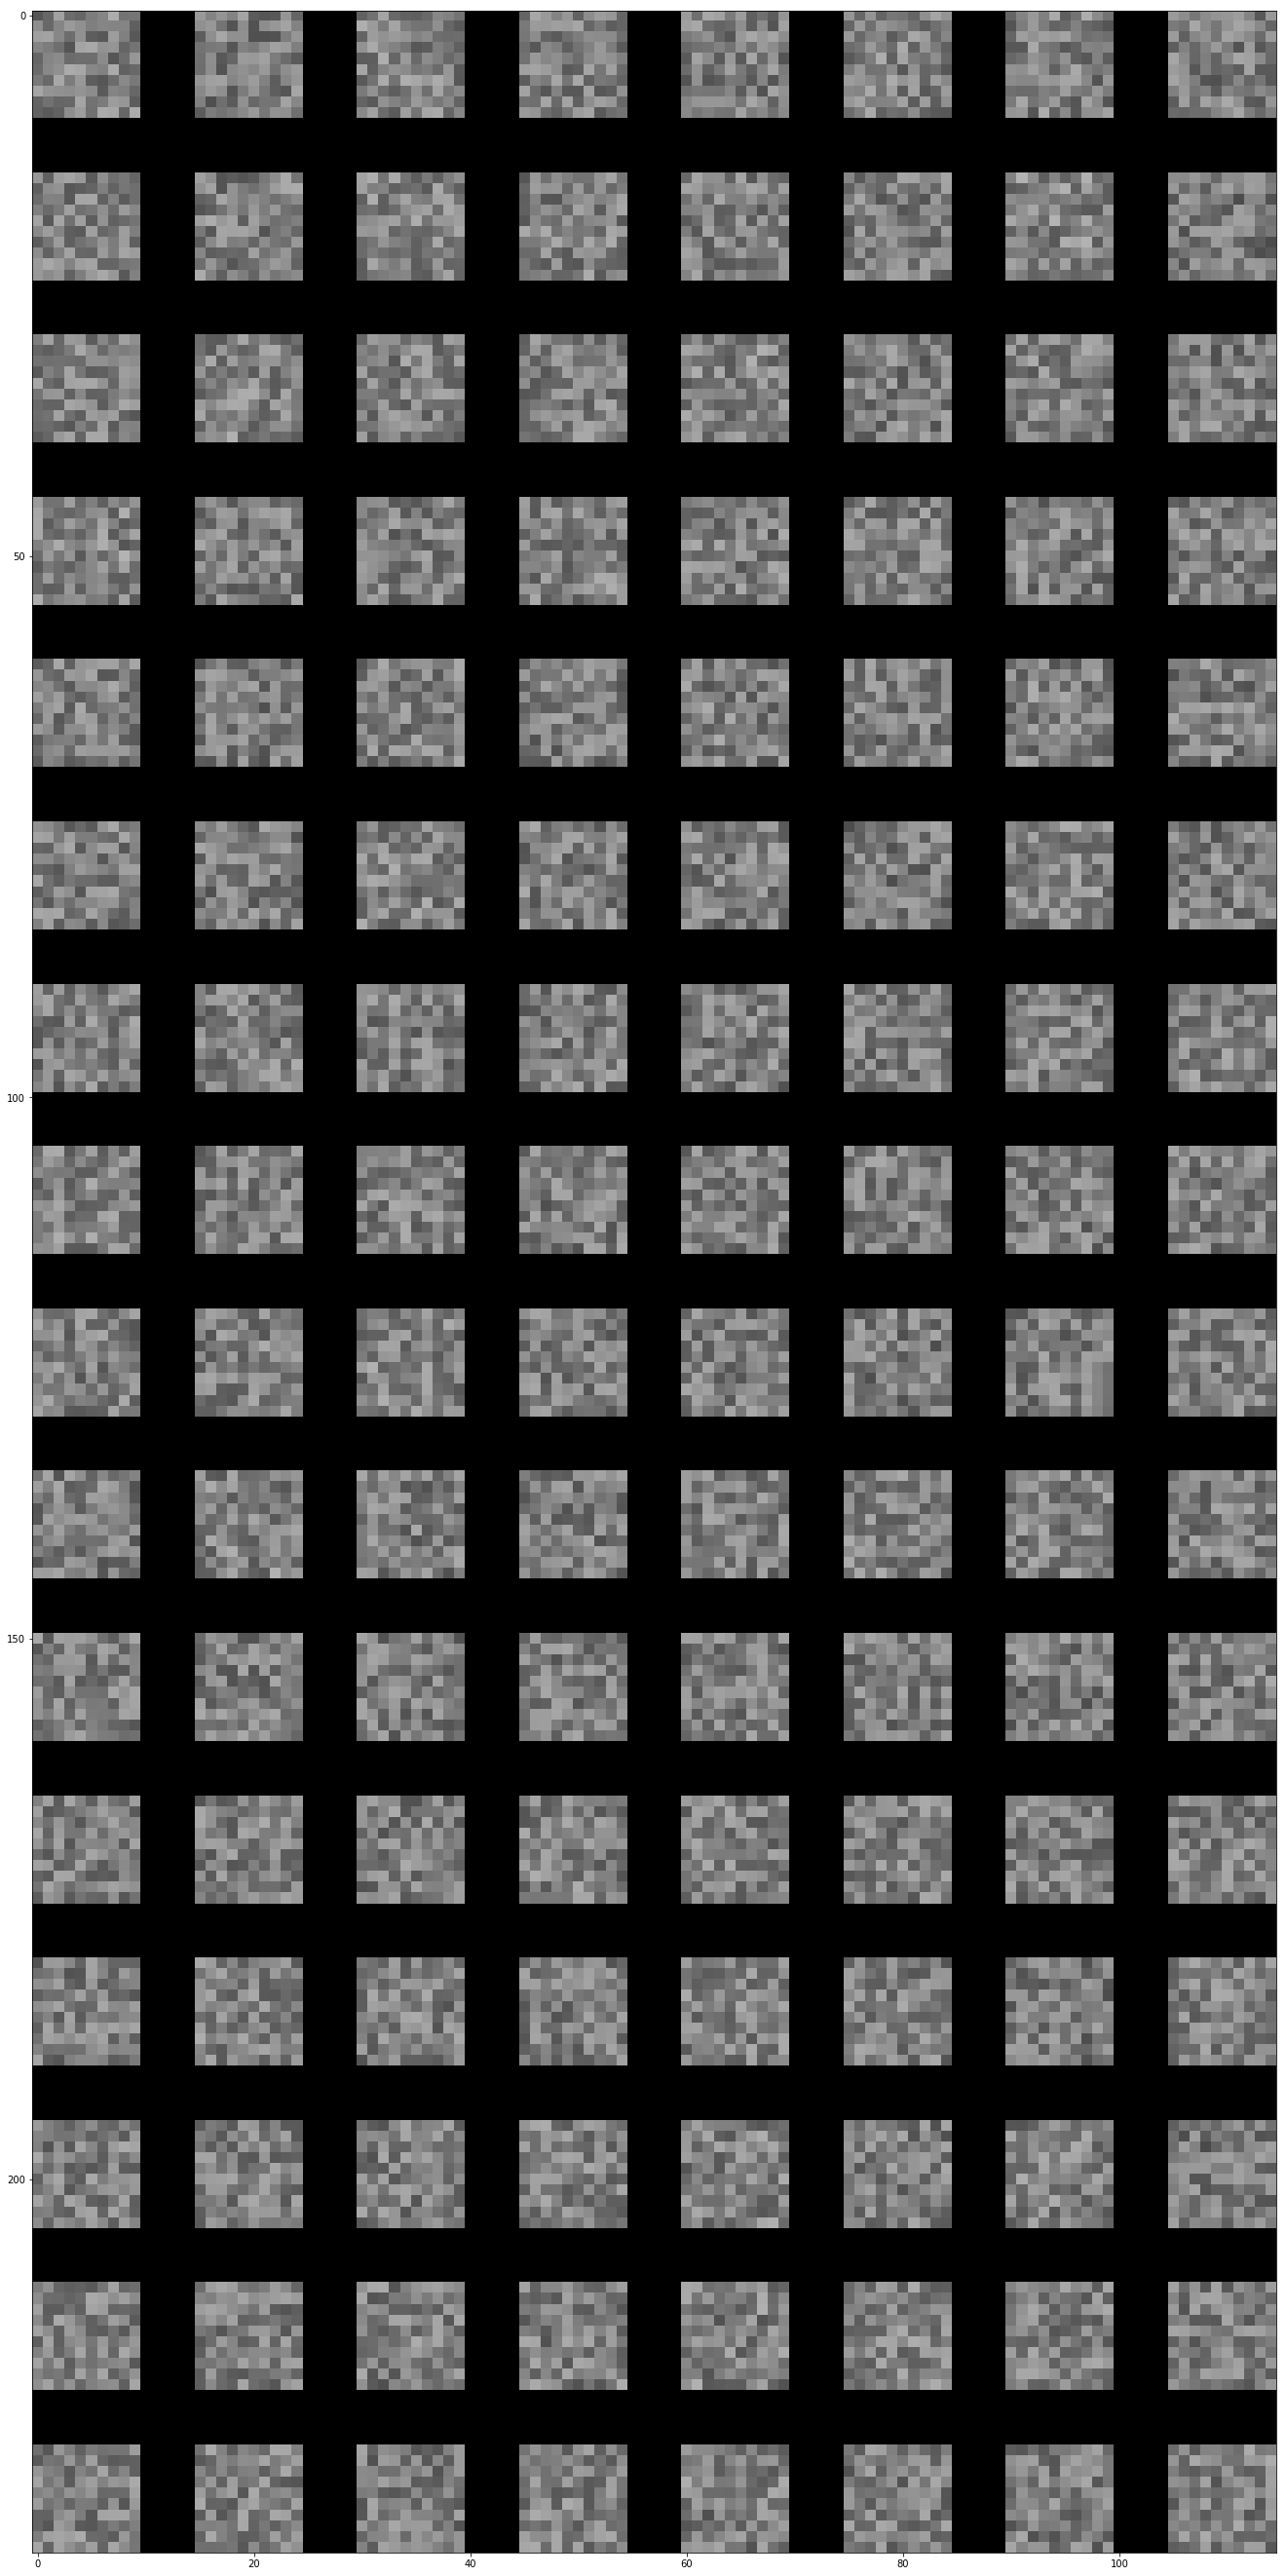

conv2d_transpose_78


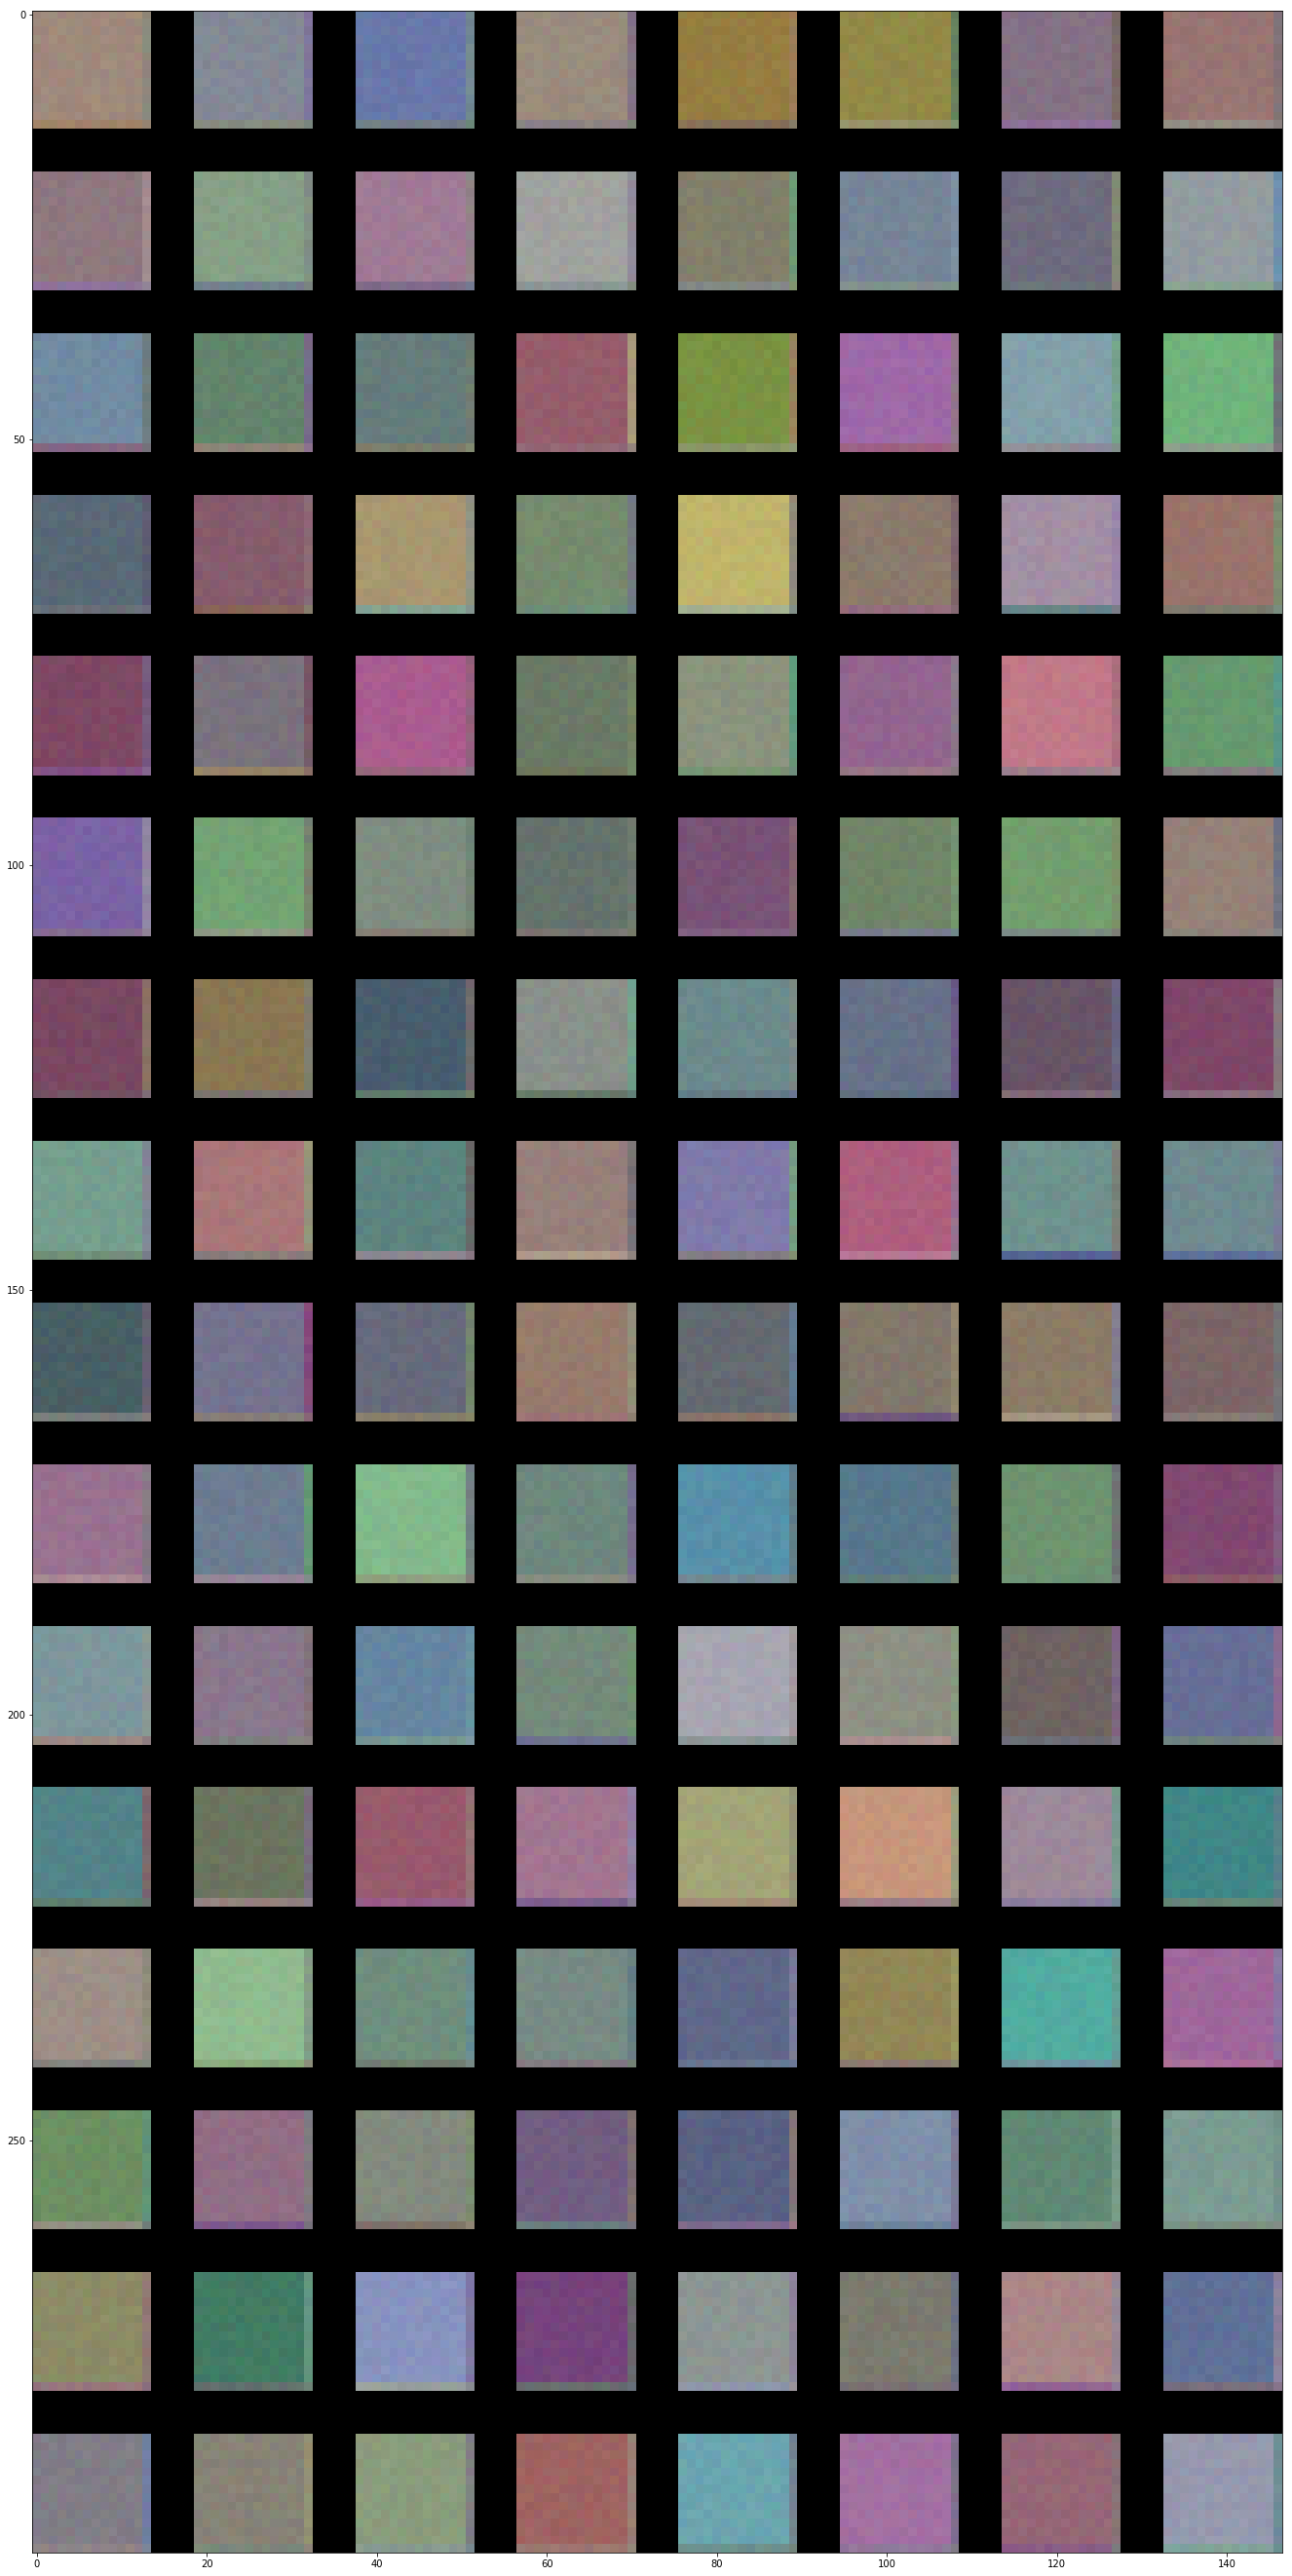

conv2d_transpose_79


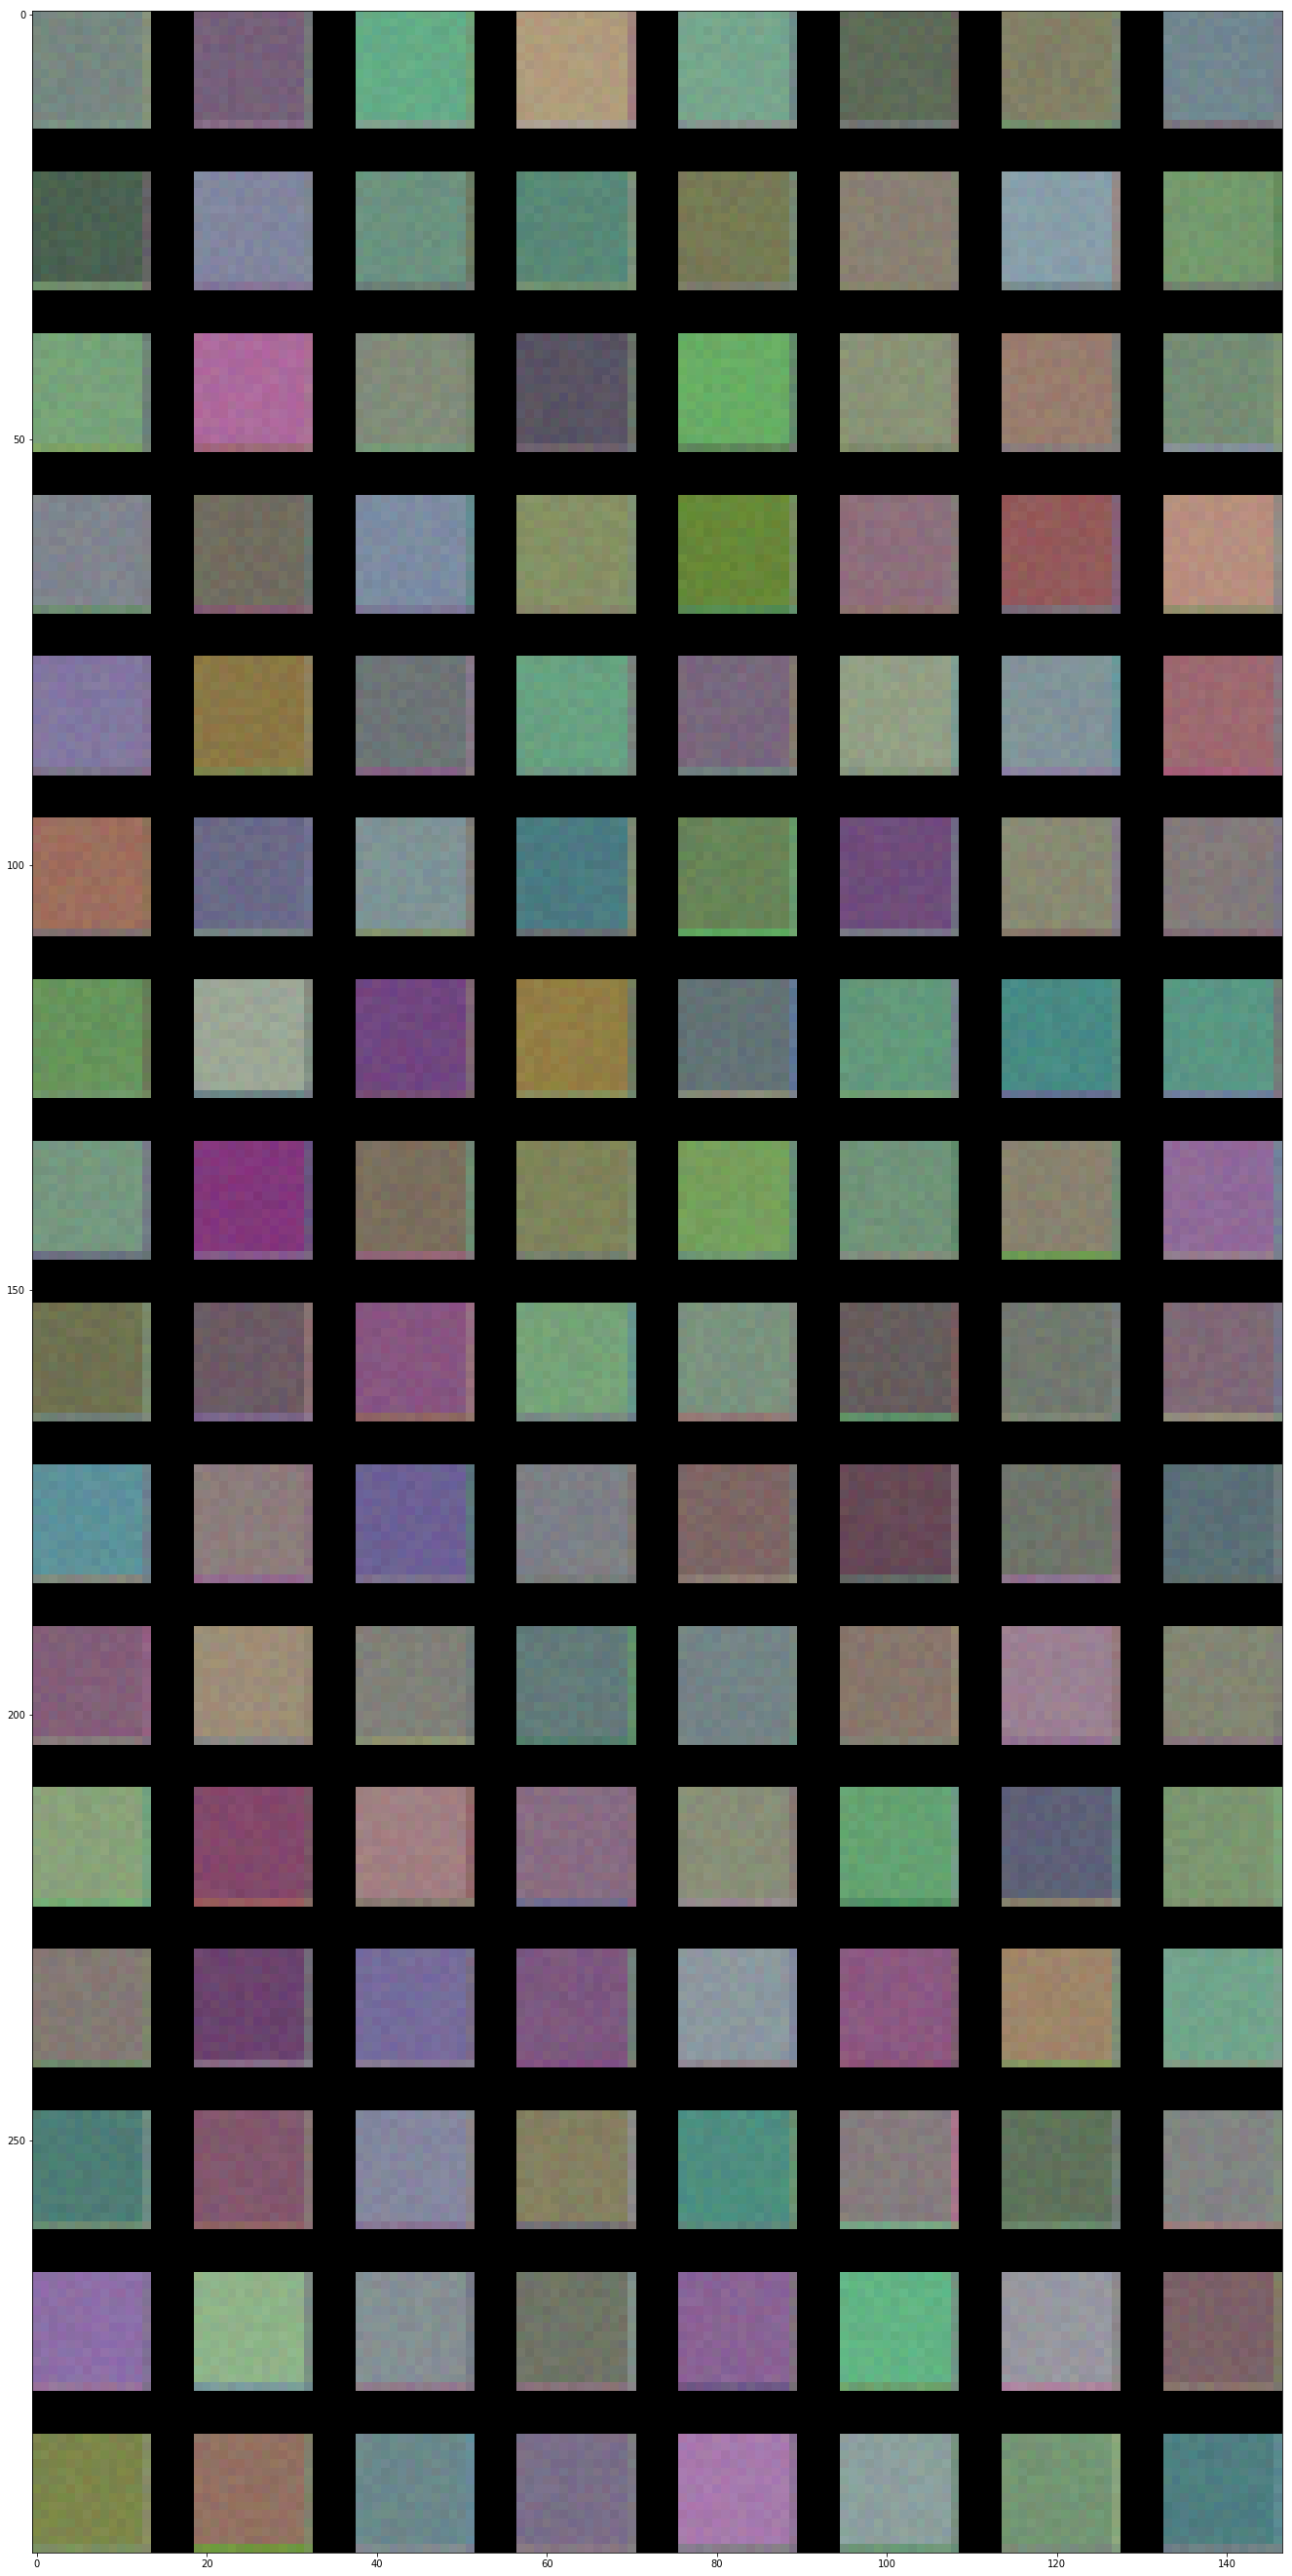

In [6]:
for layer_name in ['conv2d_transpose_77', 'conv2d_transpose_78', 'conv2d_transpose_79']:
    visualize_layer(model, layer_name)